In [1]:
% load_ext autoreload
% autoreload 2

import re

import numpy as np
import pandas as pd

from matplotlib import pyplot as plt
%matplotlib inline

import utils

# np.set_printoptions(threshold=np.inf)

/home/group7/anaconda3/envs/johenv/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [3]:
# Data files

# article_id, article_url
SRC_ARTICLES = '/mnt/data/datasets/newspapers/guardian/articles.csv'  # shape: 626395 x 2  ( politics: 20167 )
SRC_AUTHORS = '/mnt/data/datasets/newspapers/guardian/authors.csv'  # shape: 1247646 x 2
SRC_COMMENTS = '/mnt/data/datasets/newspapers/guardian/comments.csv'
# one category, only root comments, filter out NaN, tokenized
SRC_COMMENTS_POL = '/mnt/data/group07/johannes/proc_data/politics_comments.csv'  # 1372455 x 8

In [4]:
data_articles = pd.read_csv(SRC_ARTICLES)
data_articles_pol = data_articles[data_articles['article_url'].str.contains('/politics/')]
data_authors = pd.read_csv(SRC_AUTHORS)
data_comments_pol = pd.read_csv(SRC_COMMENTS_POL)

article_ids = data_comments_pol['article_id'].unique()  # 2876 ids

In [5]:
pattern = re.compile(r'\.com\/([^\/]*)\/([^\/]*)\/')
pattern2 = re.compile(r'\.com\/([^\/]*)')

def get_category(link):
    m = pattern.search(link)
    if not m:
        m = pattern2.search(link)
        return m.group(1)
    return m.group(1)

links = data_articles['article_url'].values
categories = np.unique([get_category(x) for x in links])

In [6]:
upvotes_per_author = data_comments_pol[['author_id', 'upvotes']].groupby('author_id').sum().iloc[:, 0]
comments_per_author = data_comments_pol[['author_id', 'upvotes']].groupby('author_id').count().iloc[:, 0]
mean_upvotes_per_author = upvotes_per_author / comments_per_author

In [7]:
extracted_features = dict()
extracted_features['comment_id'] = data_comments_pol['comment_id'].values
extracted_features['upvotes'] = data_comments_pol['upvotes'].values
extracted_features['text_length'] = data_comments_pol['comment_text'].str.len().values
extracted_features['author_upvotes'] = upvotes_per_author.loc[data_comments_pol['author_id']].values
extracted_features['author_comments'] = comments_per_author.loc[data_comments_pol['author_id']].values
extracted_features['mean_author_upvotes'] = mean_upvotes_per_author.loc[data_comments_pol['author_id']].values
extracted_features['rank'] = data_comments_pol.groupby('article_id')['timestamp'].rank(method='dense').astype(int)
extracted_features['total_upvotes'] = data_comments_pol.groupby('article_id')['upvotes'].transform('sum')
extracted_features['total_comments'] = data_comments_pol.groupby('article_id')['upvotes'].transform('count')
extracted_features['rel_upvotes'] = [
    (upvotes / (total_upvotes or 1)) * 100
    for upvotes, total_upvotes
    in zip(extracted_features['upvotes'], extracted_features['total_upvotes'])
]
extracted_features = pd.DataFrame.from_dict(extracted_features)

In [8]:
labels = list(reversed(extracted_features.columns))
labels.remove('comment_id')
labels.remove('rel_upvotes')
labels.remove('upvotes')
labels = ['rel_upvotes', 'upvotes'] + labels

In [9]:
filtered_df = extracted_features[extracted_features['rank'] <= 10] # select only first 10 comments
filtered_df = filtered_df[filtered_df['total_upvotes'] > 20] # do not consider articles with under 10 upvotes
# filtered_df = filtered_df[filtered_df['comment_text'].str.len() > 50]
filtered_df = filtered_df[filtered_df['total_comments'] > 10] # remove articles with over under 10 comments.

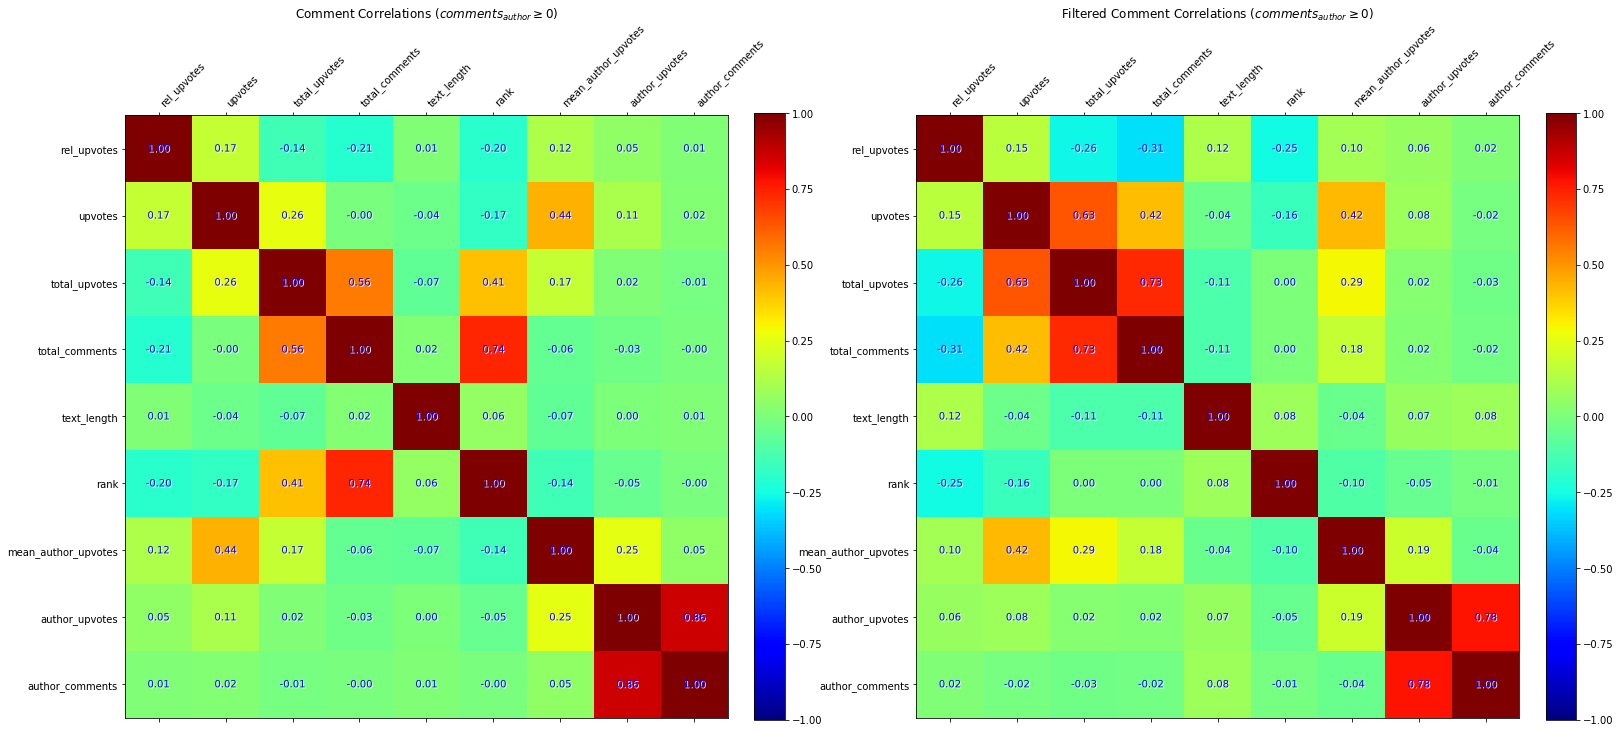

In [55]:
fig, axes = plt.subplots(1, 2, figsize=(26, 12))
utils.viz.plot_correlations(extracted_features[labels], ax=axes[0])
utils.viz.plot_correlations(filtered_df[labels], ax=axes[1], is_filtered=True)
fig.savefig(f'correlations-comparison.pdf')

### Visualize text_length vs label

In [11]:
top_bot_perc = 0.25  # <= 0.5
num_ranks = 10
num_rows=filtered_df.shape[0]
N = int((num_rows * top_bot_perc) / num_ranks)

In [12]:
res_pos = filtered_df.groupby("rank", group_keys=False).apply(lambda g: g.nlargest(N, "rel_upvotes", keep="last"))
res_neg = filtered_df.groupby("rank", group_keys=False).apply(lambda g: g.nsmallest(N, "rel_upvotes", keep="first"))
res_pos['class'] = 1
res_neg['class'] = 0
if (top_bot_perc == 0.5):
    # There is a problem when the want to bin the *whole* dataset. It would result in 2 duplicates. Most likely due to 
    # rel_upvotes is the same for multiple values and it's not possible to have a clear cut.
    res = pd.merge(filtered_df, res_pos, how='left')
    res['class'] = res['class'].fillna(0)
else:
    res = pd.concat([res_pos, res_neg])
assert(res[res['class'] == 0].shape[0] == res[res['class'] == 1].shape[0]) # ensure same number of classes
assert(res['comment_id'].is_unique) # make sure we don't have duplicates

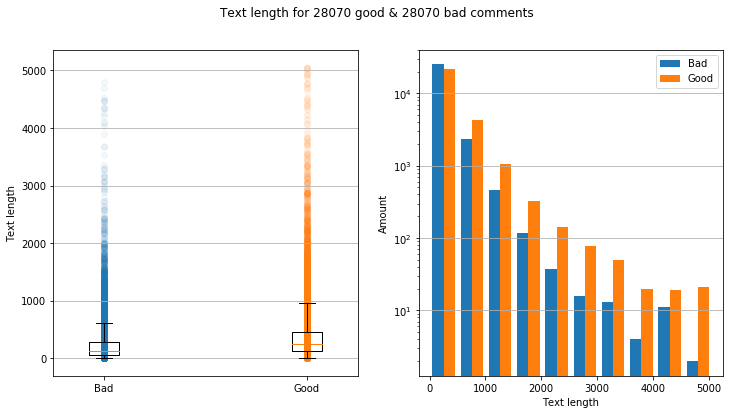

In [39]:
fig, axes = plt.subplots(1, 2, figsize=(12, 6))
fig.suptitle(f'Text length for {sum(res["class"] == 1)} good & {sum(res["class"] == 1)} bad comments')

axes[0].scatter(res[res['class'] == 0]['class'], res[res['class'] == 0]['text_length'], alpha=0.05)
axes[0].scatter(res[res['class'] == 1]['class'], res[res['class'] == 1]['text_length'], alpha=0.05)

means = res.groupby('class').mean()['text_length']
errors = res.groupby('class').std()['text_length']
axes[0].boxplot([res[res['class'] == 0]['text_length'], res[res['class'] == 1]['text_length']], positions=[0, 1], showfliers=False)
# axes[0].boxplot(res[res['class'] == 1]['text_length'])
# axes[0].bar(np.arange(2), means, 0.2, yerr=errors, , align='center', alpha=0.5, ecolor='black', capsize=10)

axes[0].set_xlim((-0.25, 1.25))
axes[0].set_xticks(np.arange(2))
axes[0].set_xticklabels(['Bad', 'Good'])
axes[0].set_ylabel('Text length')
axes[0].yaxis.grid(True)

axes[1].hist([res[res['class'] == 0]['text_length'], res[res['class'] == 1]['text_length']], log=True, label=['Bad', 'Good'])
axes[1].legend()
axes[1].set_xlabel('Text length')
axes[1].set_ylabel('Amount')
axes[1].yaxis.grid(True)

fig.savefig(f'text-len-per-class.png')

### Correlations for both classes

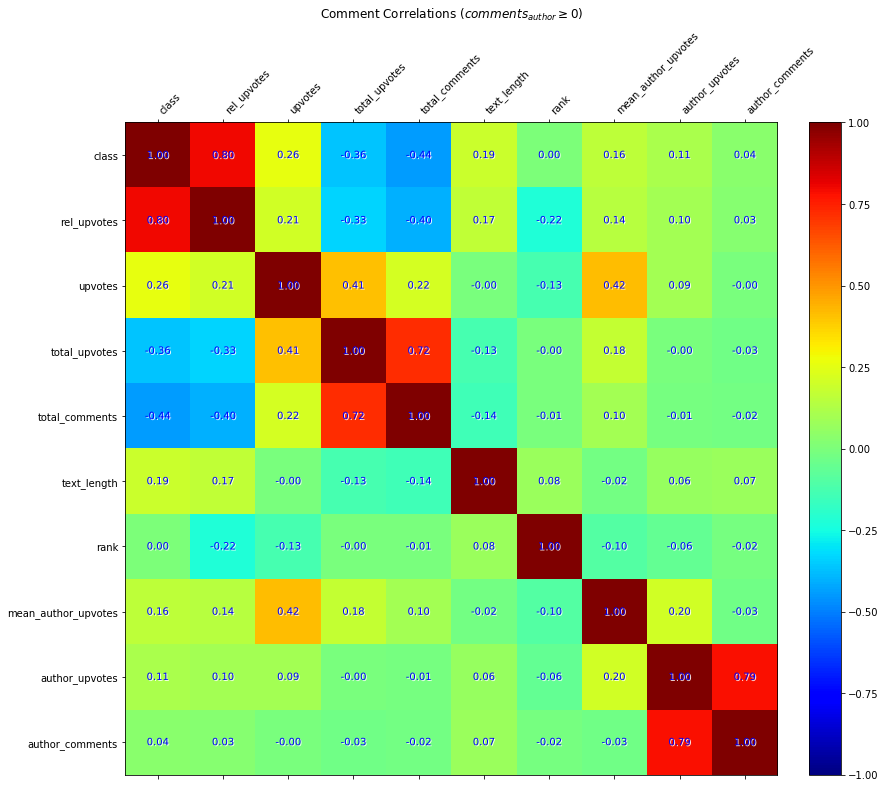

In [136]:
# fig, axes = plt.subplots(1, 2, figsize=(26, 12))
labels2 = ['class'] + list(labels)
utils.viz.plot_correlations(res[labels2])
# utils.viz.plot_correlations(filtered_df[labels], ax=axes[1], is_filtered=True)
plt.savefig(f'correlations-with-class.pdf')